# Benchmarking time series regression models

Time series extrinsic regression, first properly defined in [[1]](#references) then recently
extended in [[2]](#references), involves predicting a continuous target variable based on a time
series. It differs from time series forecasting regression in that the target is
not formed from a sliding window, but is some external variable.

This notebook shows you how to use `aeon` to get benchmarking datasets and how
 to compare results on these datasets with those published in [[2]](#references).

## Loading/Downloading data

`aeon` comes with two regression problems built-in the datasets module.
`load_covid_3month` loads a univariate regression problem, while `load_cardano_sentiment`
loads a multivariate regression problem.


In [1]:
from aeon.datasets import load_covid_3month

X, y = load_covid_3month()
X.shape

(201, 1, 84)

In [2]:
from aeon.datasets import load_cardano_sentiment

X, y = load_cardano_sentiment()
X.shape

(107, 2, 24)

The datasets used in [[2]](#references) can be found in the `tser_soton` list in the datasets module. `tser_soton_clean` includes modifiers such as _eq and _nmv for datasets that were originally unequal length or had missing values. These are cleaned versions of the datasets.

In [3]:
from aeon.datasets.tser_datasets import tser_soton

tser_soton

['AcousticContaminationMadrid',
 'AluminiumConcentration',
 'AppliancesEnergy',
 'AustraliaRainfall',
 'BarCrawl6min',
 'BeijingIntAirportPM25Quality',
 'BeijingPM10Quality',
 'BeijingPM25Quality',
 'BenzeneConcentration',
 'BIDMC32HR',
 'BIDMC32RR',
 'BIDMC32SpO2',
 'BinanceCoinSentiment',
 'BitcoinSentiment',
 'BoronConcentration',
 'CalciumConcentration',
 'CardanoSentiment',
 'ChilledWaterPredictor',
 'CopperConcentration',
 'Covid19Andalusia',
 'Covid3Month',
 'DailyOilGasPrices',
 'DailyTemperatureLatitude',
 'DhakaHourlyAirQuality',
 'ElectricityPredictor',
 'ElectricMotorTemperature',
 'EthereumSentiment',
 'FloodModeling1',
 'FloodModeling2',
 'FloodModeling3',
 'GasSensorArrayAcetone',
 'GasSensorArrayEthanol',
 'HotwaterPredictor',
 'HouseholdPowerConsumption1',
 'HouseholdPowerConsumption2',
 'IEEEPPG',
 'IronConcentration',
 'LiveFuelMoistureContent',
 'LPGasMonitoringHomeActivity',
 'MadridPM10Quality',
 'MagnesiumConcentration',
 'ManganeseConcentration',
 'MethaneMonito

You can download and load these problems from `.ts` files with the `load_regression` function. `load_from_tsfile` is also available if you want to load from file.

In [4]:
from aeon.datasets import load_regression

X_train_bc, y_train_bc = load_regression("BarCrawl6min", split="train")
X_test_bc, y_test_bc = load_regression("BarCrawl6min", split="test")
(X_train_bc.shape, y_train_bc.shape), (X_test_bc.shape, y_test_bc.shape)

(((140, 3, 360), (140,)), ((61, 3, 360), (61,)))

## Evaluating a regressor on benchmark data

With the data, it is easy to assess an algorithm performance. We will use the
`DummyRegressor` as a baseline which takes the mean of the target, and use R2 score
 as our scoring metric.

This should be familiar to anyone who has used `scikit-learn` before.

In [5]:
from sklearn.metrics import r2_score

from aeon.regression import DummyRegressor

small_problems = [
    "BarCrawl6min",
    "CardanoSentiment",
    "Covid3Month",
    "ParkingBirmingham",
    "FloodModeling1",
]

dummy = DummyRegressor()
performance = []
for problem in small_problems:
    X_train, y_train = load_regression(problem, split="train")
    X_test, y_test = load_regression(problem, split="test")

    dummy.fit(X_train, y_train)
    pred = dummy.predict(X_test)

    mse = r2_score(y_test, pred)
    performance.append(mse)

    print(f"{problem}: {mse}")

BarCrawl6min: -0.012403529243674827
CardanoSentiment: -0.21576890538877036
Covid3Month: -0.004303695576216793
ParkingBirmingham: -0.0036438945855674643
FloodModeling1: -0.0016071827276951112


## Comparing to reference/published results

How do the dummy results compare to the published results in [[2]](#references)? We can use the 
`get_estimator_results` and `get_estimator_results_as_array` methods to load 
published results.

`get_available_estimators` will show you the available estimators with stored
 results the task.

In [6]:
from aeon.benchmarking.results_loaders import get_available_estimators

get_available_estimators(task="regression")

,regression
0,1NN-DTW
1,1NN-ED
2,5NN-DTW
3,5NN-ED
4,CNN
5,DrCIF
6,FCN
7,FPCR
8,FPCR-b-spline
9,FreshPRINCE


`get_estimator_results` will load the results to a dictionary of dictionaries with regressors and datasets as the keys. ParkingBirmingham was originally unequal length, so we remove the _eq from the end of the results key to match the dataset name using a parameter.

In [7]:
from aeon.benchmarking.results_loaders import get_estimator_results

regressors = ["DrCIF", "FreshPRINCE"]
results_dict = get_estimator_results(
    estimators=regressors,
    datasets=small_problems,
    num_resamples=1,
    task="regression",
    measure="r2",
    remove_dataset_modifiers=True,
)
results_dict

{'DrCIF': {'BarCrawl6min': 0.44579994072037,
  'CardanoSentiment': -0.3243974127240141,
  'Covid3Month': 0.0710586822956002,
  'ParkingBirmingham': 0.7139985894810016,
  'FloodModeling1': 0.8965591366052275},
 'FreshPRINCE': {'BarCrawl6min': 0.3936563948097531,
  'CardanoSentiment': -0.1300226564057678,
  'Covid3Month': 0.1888015511133555,
  'ParkingBirmingham': 0.7304688812606739,
  'FloodModeling1': 0.9296442893073922}}

`get_estimator_results` will instead load an array. Note that if multiple resamples are loaded, the results will be averaged using this function.

In [8]:
from aeon.benchmarking.results_loaders import get_estimator_results_as_array

results_arr, names = get_estimator_results_as_array(
    estimators=regressors,
    datasets=small_problems,
    num_resamples=1,
    task="regression",
    measure="r2",
    remove_dataset_modifiers=True,
)
results_arr

array([[ 0.44579994,  0.39365639],
       [-0.32439741, -0.13002266],
       [ 0.07105868,  0.18880155],
       [ 0.71399859,  0.73046888],
       [ 0.89655914,  0.92964429]])

The names of the datasets are also returned as missing values are removed from the results by default. Each row corresponds to a dataset and each column to a regressor.

In [9]:
names

['BarCrawl6min',
 'CardanoSentiment',
 'Covid3Month',
 'ParkingBirmingham',
 'FloodModeling1']

we just need to align our results from the website so they are aligned with the
results from our dummy regressor

Do the same for our dummy regressor results

In [10]:
import numpy as np

regressors = ["DrCIF", "FreshPRINCE", "Dummy"]
results = np.concatenate([results_arr, np.array(performance)[:, np.newaxis]], axis=1)
results

array([[ 0.44579994,  0.39365639, -0.01240353],
       [-0.32439741, -0.13002266, -0.21576891],
       [ 0.07105868,  0.18880155, -0.0043037 ],
       [ 0.71399859,  0.73046888, -0.00364389],
       [ 0.89655914,  0.92964429, -0.00160718]])

## Comparing Regressors

`aeon` provides visualisation tools to compare regressors.

We can plot the results against each other. This also presents the wins and losses
and some summary statistics.

(<Figure size 800x800 with 1 Axes>,
 <Axes: xlabel='DrCIF r2\n(mean: 0.3606)', ylabel='FreshPRINCE r2\n(mean: 0.4225)'>)

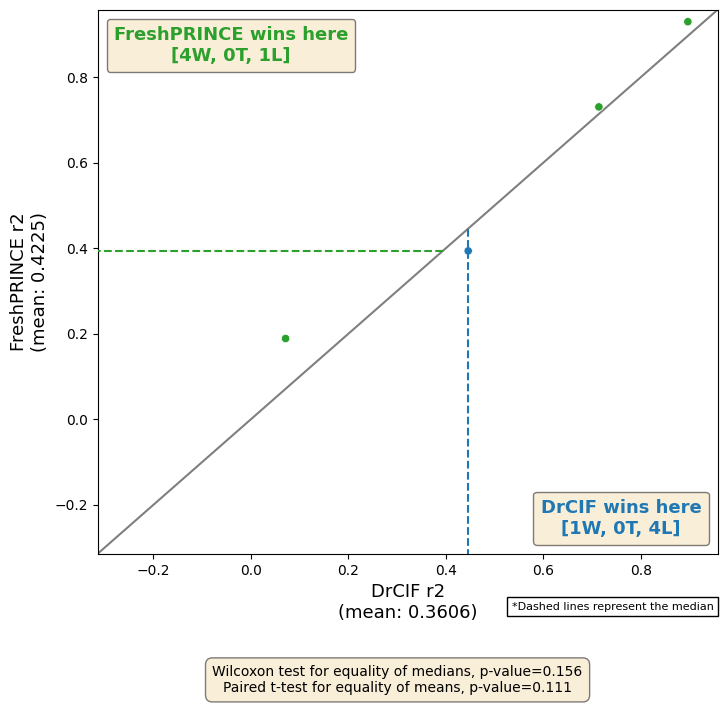

In [11]:
from aeon.visualisation import plot_pairwise_scatter

plot_pairwise_scatter(
    results[:, 0],
    results[:, 1],
    "DrCIF",
    "FreshPRINCE",
    metric="r2",
)


We can plot the results of multiple regressors on a critical difference diagram [[3]](#references),
which shows the average rank and groups estimators by whether they are significantly
different from each other.

(<Figure size 600x220 with 1 Axes>, <Axes: >)

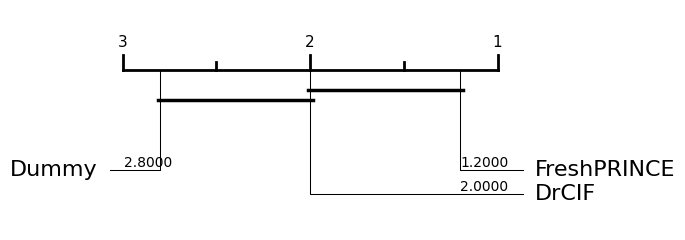

In [12]:
from aeon.visualisation import plot_critical_difference

plot_critical_difference(results, regressors)

A function for plotting a boxplot is also available.

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

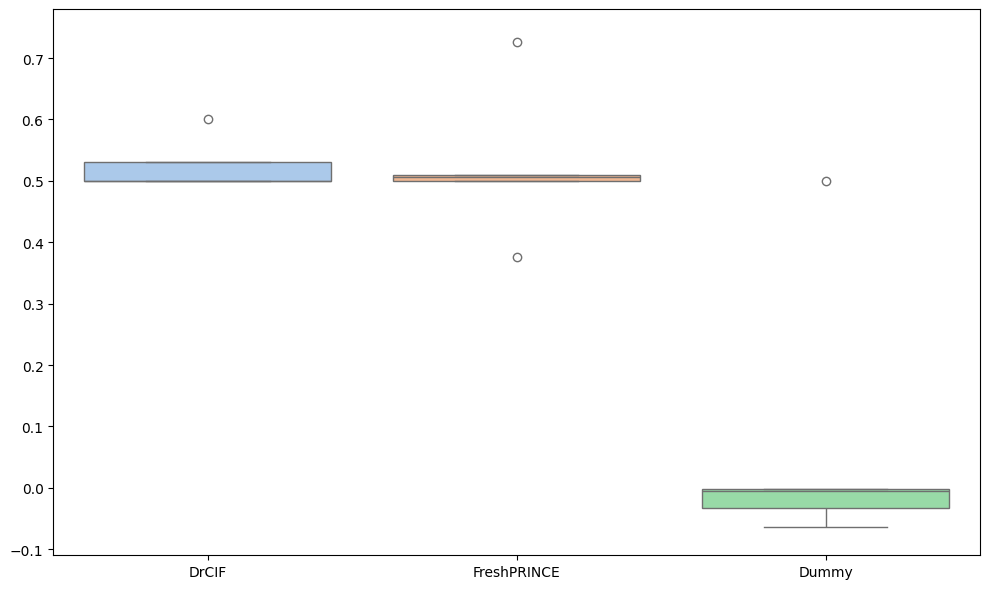

In [13]:
from aeon.visualisation import plot_boxplot

plot_boxplot(results, regressors, relative=True, plot_type="boxplot")

Sometimes it is interesting to compare the performance of estimators on a single specific dataset. We use the BarCrawl6min dataset here.

In [14]:
from aeon.regression import DummyRegressor
from aeon.regression.feature_based import FreshPRINCERegressor

fp = FreshPRINCERegressor(n_estimators=10, default_fc_parameters="minimal")
fp.fit(X_train_bc, y_train_bc)
y_pred_fp = fp.predict(X_test_bc)

d = DummyRegressor()
d.fit(X_train_bc, y_train_bc)
y_pred_d = d.predict(X_test_bc)

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'FreshPRINCE - Covid3Month'}, xlabel='Actual values', ylabel='Predicted values'>)

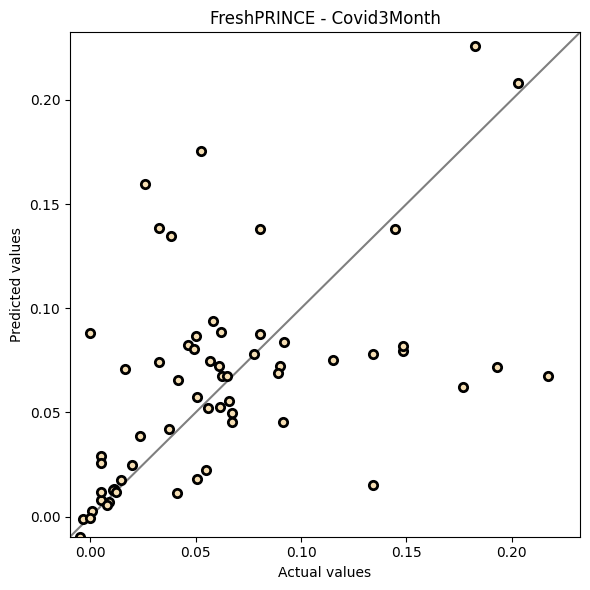

In [15]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_bc, y_pred_fp, title="FreshPRINCE - Covid3Month")

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Dummy - Covid3Month'}, xlabel='Actual values', ylabel='Predicted values'>)

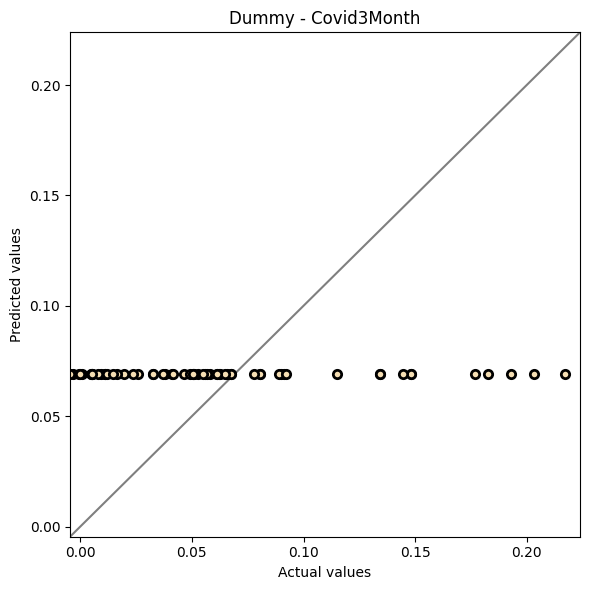

In [16]:
plot_scatter_predictions(y_test_bc, y_pred_d, title="Dummy - Covid3Month")

## References <a id='references'></a>

[1] Tan, C.W., Bergmeir, C., Petitjean, F. and Webb, G.I., 2021. Time series extrinsic regression: Predicting numeric values from time series data. Data Mining and Knowledge Discovery, 35(3), pp.1032-1060.

[2] Guijo-Rubio, D., Middlehurst, M., Arcencio, G., Silva, D.F. and Bagnall, A., 2024. Unsupervised feature based algorithms for time series extrinsic regression. Data Mining and Knowledge Discovery, pp.1-45.

[3] Garcia, S. and Herrera, F., 2008. An Extension on" Statistical Comparisons of Classifiers over Multiple Data Sets" for all Pairwise Comparisons. Journal of machine learning research, 9(12).